# 2.9.Stepik ML contest

Мы продолжаем предсказывать отток студентов с курса по Анализу данных в R. В этом модуле мы завершим подготовительный этап и доведем данные до состояния, когда можно обучить первый вариант модели!

## step 2

Итак, возвращаемся к нашей практической задаче - предсказание оттоков пользователей со степика.

В первом модуле мы закончили довольно важный и при этом довольно понятный этап для любой задачи, возникающей в `machine-learning`, аналитике, `data-mining` и т.д. У нас просто были какие-то сырые данные, и мы привели их к более понятному виду. Мы их смёрджили, предобработали, агрегировали. Мы как минимум получили понятную историю в этих данных, посмотрели, что всё с этими данными всё хорошо и с ними можно работать.

На самом деле ещё даже до применения моделей (особенно когда речь идёт о продуктовой аналитике и у нас есть цель скажем, разобраться почему пользователи дропаются) уже какие-то гипотезы можно получить, просто посмотрев на такой промежуточный агрегат. 

Допустим, уже сейчас можно изучить последние сессии дропнувшихся пользователей и убедиться в том, что один из таких частых сценариев - это когда человек натыкается на какую-то сложную задачу, очень долго подряд не может её решить и потом уже никогда к нашему курсу не возвращается.

В своё время, когда автор курса работал в степике, он первым делом пробежался по своим курсам и отредактировал довольно много задач. Особенно в курсе по `R`. Буквально в первом-втором уроке была сложная задача на работу с временными рядами и временные ряды до этого не обсуждались. Автору казалось, что самостоятельная работа слушателей с материалами по данной теме приведёт к положительному эффекту. На практике выяснилось, что огромное количество людей доходили до этой задачи, не могли её решить и больше никогда не появлялись на этом курсе.

И тут уже некоторый описательный анализ данных помог эту задачу изменить. на была перенесена в конец урока, выведена под звёздочку, было сказано, что необязательно решать её сейчас, поскольку можно пройти по курсу вперёд, а потом вернуться к её решению. И это в дальнейшем повлияло на результат.

Таким образом, некоторые интересные вещи ещё до моделирования, до обучения могут броситься в глаза.

Сейчас перед нами стоит задача продвинуться чуть дальше и привести данные к тому формату, когда уже можно будет обучать какие-то модели, делать интересные предсказания. 

Давайте переформулируем нашу задачу на язык машинного обучения. Наша цель как можно раньше предсказать, что пользователь уйдёт с курса `"Анализ данных в R"` и давайте для начала решим первую версию задачи. Для этого ответим на опрос - "можем ли мы, анализируя поведения пользователя за первые N дней, предсказать тот факт, что пользователь пройдёт курс до конца или дропнется и не наберёт нужное количество баллов?".

## Подгрузка предыдущих наработок

Подгружу в данный ноутбук наши ранее выполненные наработки.

In [71]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# reading datasets
events_data = pd.read_csv('event_data_train.zip', compression='zip')
submissions_data = pd.read_csv('submissions_data_train.zip', compression='zip')

In [72]:
# adding new columns
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

# calculating for each user count correct submimit
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175

In [73]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [74]:
# Проверка, что данные не потеряны
users_data.user_id.nunique()

19234

In [75]:
events_data.user_id.nunique()

19234

Количество строк совпало, значит мы ничего не потеряли.

## step 3

На предыдущем этапе мы остановились на том, что предобработали данные и сделали сводную выгрузку users_data. 

Из сырых логов и разных источников мы свели все данные воедино. И, в принципе, можно наполнить эту табличку ещё несколькими важными колонками, но сейчас основная идея этой таблички была в том, что у нас были сырые логи, а теперь есть датафрейм users_data, в котором про каждого пользователя мы знаем:

+ его статус на текущий момент (правда ли, что он закончил курс успешно / дропнулся), + сколько он сделал попыток,   
+ когда его последний раз видели на курсе.

То есть пока ещё датафрейм, наверное, не очень применим для какого-то машинного обучения, хотя какие-то гипотезы можно уже и отсюда повытаскивать. Однако этот датафрейм нам точно потребуется ещё не раз, потому что, например, его можно использовать для разметки нашей выборки.

Теперь давайте подбираться к нашей первой задаче машинного обучения - попробуем, анализируя поведение пользователя за его первые несколько дней, после которых он начал курс, предсказать - правда ли, что он успешно закончит курсу или дропнется с него.

Для начала можно предположить, что мы можем использовать, скажем, первые 2-3 дня. Вообще, есл бы мы решали эту задачу по-настоящему - это как раз тот пример. когда у нас нет готового правильного ответа на вопрос "сколько первых дней нам нужно, чтобы предсказать уйдёт пользователь с курса или нет?". Поэтому можно попробовать разные пороги, нащупать какой-то оптимальный баланс времени и качества. Понятное дело, что если мы будем использовать первые две недели, то мы слишком поздно будем реагировать. Если мы будем пытаться предсказывать поведение пользователя за первые два часа с момента его начала работы с курсом - это, конечно, здорово, но возможно мы потеряем в точности.

Поэтому нужно экспериментировать и давайте начнём, например, с 3-х дней. Для начала можно в принципе проверить насколько это адекватно, потому что у нас есть данные про то сколько уникальных дней пользователь потратил на прохождение курса - колонка day. Можно посчитать медиану, предварительно отобрав только те наблюдения, у которых `passed_course = True`.

Обратите внимание, что это уже вектор True\False, поэтому можно просто передать его в качестве фильтра. Хотя это возможно не очень правильно, но так можно сделать.

добавим ещё одну колонку - когда пользователь первый раз появился на курсе.

In [76]:
users_data[users_data.passed_course].day.median()

21.0

Мы видим, что медиана у нас 20 дней. Если построить гистограмму, то мы увидим типично скошенную метрику.

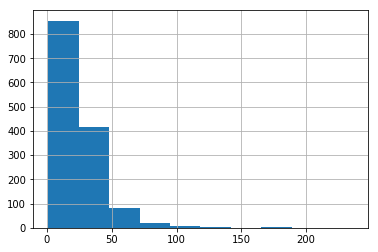

In [77]:
users_data[users_data.passed_course].day.hist()

Кстати, это тоже интересное наблюдение - большинство метрик, как-то характеризующих взаимодействие пользователя с продуктом, очень часто распределены не нормально. Скажем, процент лайков, репостов в соцсетях, количество дней, затраченных пользователями на прохождение курса, число решённых задач и т.д. Скорее всего это будет ненормальное распределение (готовьтесь к этому). Такие классические симметричные распределения на самом деле в реальной практике на самом деле попадаются довольно редко.

Мы видим, что медиана 20, т.е. половина пользователей решает более 20 дней, поэтому 3 дня кажется адекватным порогом. Попробуем предсказать

## step 4

Итак, наша первая задача: отобрать те наблюдения, которые мы будем использовать для обучения `events_data`, т.е. события, происходящие с пользователем в течение его первых трёх дней из общего датафрейма.

Сейчас здесь для каждого пользователя лежит вся его информация про все его действия на протяжении всей истории, доступной нам в этой выгрузке. Нам бы нужно для каждого юзера отобрать только его события, укладывающиеся в диапазон от его первого события плюс 3 дня. 

Как же это сделать?

Отберём данные о первых активных действиях пользователя на курсе:

In [78]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [79]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


Теперь мы можем добавить эту информацию в наш исходный датасет:

In [80]:
users_data = users_data.merge(user_min_time, how='outer')

In [81]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Теперь у нас есть информация не только про то, когда пользователь впервые был на курсе, но и когда он завершил своё действие на курсе - какой у него был последний `timestamp`.

Теперь смотрите, довольно необычная задача и такую фильтрацию мы ещё не делали. Нам теперь нужно для данных, хранящихся в `events_data`, отобрать только наблюдения, проходящие по некоторому условию, а именно - у нас для каждого юзера есть некоторое его окно, в которое мы можем уместить нужные нам наблюдения, и их то и нужно отобрать.

Задача довольно интересная, потому что это такая нетривиальная фильтрация и решить её можно несколькими способами.

Давайте попробуем начать с самого неправильного.

### "Неправильный" способ

На самом деле неправильным его можно назвать в кавычках, это такой наиболее интуитивный способ. 

Смотрите, что у нас происходит. Если мы хотим отобрать для каждого пользователя только нужную часть данных о нём, мы могли бы воспользоваться вот таким подходом:

In [82]:
event_data_train = pd.DataFrame() # сюда сложим уже отобранные данные

А дальше просто написали бы такой цикл:

In [83]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    break

In [84]:
min_user_time

1472827464

In [85]:
user_id

1

Проверим, что всё правильно:
+ выведем первые несколько строк из `users_data`
+ посмотрим какое значение `min_timestamp` у записи с `user_id = 1`

In [86]:
users_data[['user_id', 'min_timestamp']].head(3)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476


Да, всё верно.

А теперь сделаем нужную фильтрацию из исходного датафрейма

In [87]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
    break

**================================================= Важно ========================================================**

Выход `break` из цикла после первой итерации - хорошая привычка. Когда вы разрабатываете какой-то сложный цикл - не нужно ждать, пока он весь отработает, есть смысл проверить корректность работы первой итерации.
И только потом прогружать его полностью.

**================================================================================================================**

In [88]:
user_events_data

,step_id,timestamp,action,user_id,date,day
1347416,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02
1347417,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02


Мы получили датафрейм для первого юзера из событий в его первые 3 дня на курсе. Всё корректно отработало - убираем `break` из цикла и наращиваем наш итоговый датафрейм.

In [226]:
for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]
    
    event_data_train.append(user_events_data)

KeyboardInterrupt: 

Но! Выполнение данного блока кода займёт очень длительное время. Причина в том, что такого рода операции над датафреймами очень затратные, поскольку выполняются: фильтрация, append не очень эффективен.

В общем, такой подход выбивается из кода, написанного ранее и такой код не `pandas way`.

А что же тогда `pandas way`?

Одной командой, одной маской сделать `event_data_train`, указав, что это `event_data` с некоторым условием:

In [ ]:
event_data_train = event_data[]

То есть это такой путь, при котором наша задача решилась одним запросом на фильтр.

Это довольно интересная задача и решить её можно разными способами. Это немного неочевидный ответ как её решить. 

## step 5

Итак, давайте попробуем придумать как нам сделать один запрос к нашим `events_data`, чтобы получить нужный результат, точнее, чтобы отобрать для каждого пользователя только события, вписывающиеся в промежуток первых трёх дней после начала курса.

Как к этой задачке подойти?

Мы не можем сделать фильтрацию только по `user_id`, нам нужно сложное комбинированное условие по `user_id` и `timestamp`. Для каждого `user_id` границы `timestamp` разные и как к этому подойти - непонятно.

Давайте создадим в `events_data` новую колонку `user_time`:

In [89]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

Инструкция `map(str)` применит к каждому значению в столбце датафрейма функцию str() - т.е. приведёт все значения к строковому типу.

In [90]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Мы сшили идентификатор пользователя со значениями времени. 

Вынесем переменную порогового значения для `timestamp`, которую мы будем использовать далее:

In [91]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

Теперь давайте для каждого пользователя сделаем связку его идентификатора и максимального значения, которое можно использовать для того, чтобы продолжать работу.

У нас есть уже подготовленный `user_min_time` и давайте теперь сделаем заготовленную серию, в которой для каждого пользователя будут проставлены его максимальное значение времени и сам идентификатор пользователя, после которого мы уже не будем эти данные использовать.

In [92]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

In [23]:
user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

## step 6

Давайте вынесем результат этого вычисления в отдельную колонку. Можем, например, добавить в наш датафрейм, хранящий минильное время юзера. Это будет как раз минимум и максимум, который мы будем использовать для отсечения событий.

In [93]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

Теперь начинается самое интересное - нам нужно просто данные про пороговое значение для каждого пользователя добавить в наш датафрейм `events_data`.

Давайте сделаем мёрдж наших данных с датафреймом `user_min_time`, отобрав из него только нужные нам данные

In [94]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [95]:
events_data.shape

(3480703, 8)

In [96]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Нам теперь для каждого пользователя достаточно просто узнать - "правда ли, что его время выполнения каждого действия вписыается в нужный нам диапазон?".

И тут нам на помощь приходит то, что строки можно сравнивать так же как инты.

In [97]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [98]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [99]:
events_data_train.shape

(1014985, 8)

## step 8

Вот из таких мелочей и складывается большая часть времени работы с кодом в `data science`. Умение поперегонять данные в разные форматы, агрегировать, мерджить и т.д. 

И здесь важно, чтобы этот этап не упирался, во-первых, в ваше личное время - не нужно сидеть и 2 часа мёрджить две таблички. Хотя, к сожалению, по началу всё так и выглядит.

И, во-вторых, важно, чтобы это не упиралось в производительность самой системы. Наш датафрейм в 3,5 млн записей - это уже тот датафрейм, на котором можно упереться в проблемы с производительностью. Например, на прошлом примере цикл for всё очень загрузил на большом объёме данных.

Фильтрация, т.е. отбор данных - очень частая операция в нашей работе. Используя её нужно всегда задавать себе вопрос - а можно ли получить результат одним запросом, одной маской(одним логическим условием) к исходным данным.

И здесь нам помогают мерджи. Поскольку мы можем замерджиться с другими данными, сделать новую колонку и сравнения логические поколоночно, которые происходят очень быстро.

В итоге получается ответ, отрабатывающий практически мгновенно, хотя пробегает по этим же огромным данным, но не для каждого юзера в отдельности, а сразу для всех наблюдений, дающих нам нужный результат.

## step 9

На самом деле стоит отметить, что в примере с этим интересным мерджем, а потом фильтром по колонке (начало курса и некоторый порог) - нам необязательно было склеивать `timestamp` с `user_id`, достаточно просто было сделать колонку, отвечающую для каждого пользователя за начало курса и колонку, которая будет хранить пороговое значение. И для каждой строки можно было бы сделать обычное сравнение.

Здесь же хотелось показать, что иногда полезно сделать необычные комбинации двух колонок, сливать в одну и потом это иногда может пригодиться, но конкретно в данном случае можно было завести две новые колонки и сделать интересный фильтр.

Мораль всей этой истории скорее в том, что очень часто приходится делать довольно сложные фильтры по некоторому условию, которое зависит от некоторой величины в данных. 

Например, у нас есть какой-нибудь `user_id` и для каждого `user_id` нужно сделать какой-нибудь хитрый фильтр, для каждого свой. И здесь есть 2 пути:
+ итерабельно в цикле говорим: для каждого `user_id` делаем подмножество исходного датафрейма, в подмножестве отбираем нужный кусочек, делаем `append` и снова находим следующего юзера
+ делаем мердж с вспомогательным датасетом и после мерджа отбор нужных данных происходит за счёт сравнения двух колонок

Такое часто случается в работе, поэтому если у вас есть какой-то сложный и необычный фильтр, который нужно сделать с динамическим условием, то можно посмотреть в сторону мерджа дополнительной информации, которая в дальнейшем поможет при анализе.


## step 10

Но как бы это всё ни звучало красиво, на практике всегда нужно убеждаться в том, что мы нигде ничего не сломали.

Давайте проверим максимальное число дней:

In [100]:
events_data_train.groupby('user_id').day.nunique().max()

4

Такое может быть, например, когда пользователь начал 1-го числа в середине дня, и трое суток в этом случае заденут и четвёртое число тоже. Но число больше 4-х мы уже никак не можем ожидать в наших данных, потому что это заложено в наш с вами порог. 

Если бы мы поменяли порог, то вполне ожидаемо мы получили бы большее число. Но сейчас наши данные содержат только ожидаемую информацию.

Вот такие проверки на каждом таком ключевом этапе обязательно делайте, потому что иначе мы начинаем играть с машинным обучением в "испорченный телефон". Мы думаем, что обучаем модель на 3-х первых днях, на самом деле обучаем на 7, потому что где-то в коде случайно ошиблись, тестируем на 3-х. Всё получается странно и непонятно где что происходит. Поэтому обязательно приучайте себя к такой `check-проверке`: сделали важный этап - добавили строчку кода и проверили, то всё работает ожидаемо.

## step 11

Чтобы сэкономить наше время тоже самое проделаем с данными submissons_data:

In [101]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

Соберём первый простенький вариант с фичами и целевой переменной и попробуем обучить хотя бы базовую модель, чтобы посмотреть, что у нас, в принципе, что-то получается и работает. Или это бесполезная задача и никакой точности прогнозирования за первые 3 дня добиться не удастся.

Заведём датафрейм `X`, который постепенно будем наполнять данными.

In [102]:
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

In [103]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


В `X` собраны некоторые свойства юзера, которые мы получаем за первые 3 дня его обучения на `stepik`.

А дальше мы хотим посмотреть - правда ли данные за эти 3 дня можно использовать для обучения модели, которая предскажет отвалится пользователь или не отвалится в конце.

И чтобы узнать отвалится пользователь или нет в конце мы пойдём в датафрейм `users_data` и смёрджим его с финальным статусом, который у нас есть.

Из `submissions_data_train` можно достать ещё интересные данные, например, посчитаем сколько степов человек попытался решить за первые 3 дня.

In [104]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

In [105]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


Мы получили для каждого пользователя число уникальных степов, которые он попытался решить.

Давайте теперь наращивать наш датафрейм `X`, добавляя к нему всё новые фичи.

In [106]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [107]:
X.shape

(8913, 3)

In [108]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим число правильных и неправильных попыток и отношение правильности к неправильности.

Мы уже решали подобную задачу, когда подготавливали данные по всему периоду

In [109]:
submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [110]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [111]:
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


Можно сильно помочь нашим данным, упростив им задачу. Сделаем долю правильных ответов от общей суммы ответов.

In [112]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [113]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


## step 12

Давайте из данных про `events` также отберем сколько у нас было просмотрено степов суммарно. Для этого тоже сделаем мёрдж с `events_data`.

Для каждого пользователя посчитаем сколько у него было разных событий. Поскольку в данных по `events` данных больше, чем по `submits` - нам нужен `outer join` при мёрдже. 

In [114]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [115]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [116]:
X.shape

(19234, 7)

Мы можем убедиться в том, что у нас появились некоторые пропуски в данных после этого джойна. Заполним их пока нулём.

In [117]:
X = X.fillna(0)

Временно расширим датафрейм `X` для правильной разметки выборки.

Нам нужно взять данные из `user_data` про то:
+ закончил ли человек курс успешно
+ правда ли, что он уже не пытается это сделать

In [118]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [119]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Отбросим из этих данных всё лишнее

In [120]:
X[(X.is_gone_user == False) & (X.passed_course == False)].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
7,25,1.0,2.0,1.0,4.0,0.200000,40,False,False
11,32,1.0,3.0,3.0,0.0,1.000000,14,False,False
20,57,3.0,13.0,13.0,28.0,0.317073,70,False,False
30,78,1.0,2.0,2.0,0.0,1.000000,13,False,False
53,156,1.0,2.0,2.0,0.0,1.000000,10,False,False


Это все пользователи, не дошедшие до конца курса и не бросившие его ещё. А нам нужно обратное. То есть нам нужны все, кроме этим комбинаций.

Тогда обернём инструкцию выше в скобки и используем знак отрицания: `~`

In [121]:
X[~((X.is_gone_user == False) & (X.passed_course == False))].head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [122]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [123]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Теперь в `X` находятся пользователи, которые либо прошли курс, либо бросили его.

Теперь можно создать колонку, отвечающую за то - дропнулся человек с курса или его прошёл.

Сейчас за это отвечает `passed_course`, потому что мы все промежуточные варианты отобрали, когда у нас человек ещё курс не закончил, но мы не можем сказать, что он дропнулся.

Давайте это проверим.

In [124]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16590
True           False             136
               True             1254
Name: user_id, dtype: int64

Что значит этот результат?

Все пользователи, не прошедшие курс(`passed_course = False`), помечены как дропнутые (`is_gone_user = True`). А все прошедшие курс могут быть как дропнутые(`is_gone_user = True`), так и нет(`is_gone_user = False`). Которые не дропнулись - это те, кто совсем недавно курс прошёл и у них ещё какие-то данные в логах остались.

Поэтому нашей целевой переменной здесь является `passed_course`.

Давайте тогда создадим переменную `y`.

In [125]:
y = X.passed_course.map(int)

In [126]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

Обратите внимание, что в `X` у нас хранится `user_id` и кажется, что странно использовать эту колонку для обучения нашей модели, потому что она навряд ли несёт какую-то логику.

Поэтому может `user_id` перенести в индексы, чтобы он не мешал среди колонок. Но при этом не удалять его из данных, потому что потом нам будет интересно посмотреть на отдельных юзеров.

In [127]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [128]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


`X` теперь стал более похож на обучающую выборку с которой можно провести эксперименты - логистическая регрессия, дерево решений, оценка метрик, замена параметров и т.д.

Проделав всё это, можно будет ответить на вопрос - сможем ли мы предсказать отток студентов за первые несколько дней.

## step 13

Как-то так могла выглядеть подготовка к непосредственному обучению. 

Мы уже из сырых данных ввели какую-то нашу новую логику:  
+ что мы отберём наблюдения только за первые 3 дня  
+ попробуем по ним предсказать интересующую переменную  

Это уже сделать можно самостоятельно. Попробуйте обучить модель, попредсказывать разные значения разными классификаторами. Обучите логистическую регрессию, дерево решений. Поэкспериментируйте с глубиной дерева и т.д.

То, что мы делали - это такой "черновой вариант" работы в режиме онлайн. При решении длительной задачи код пишется уже более структурированно - создаются специальные обёртки, принимающие сырые данные и возвращающие уже данные нужного нам вида и формата. Это упрощает нам работу и ускоряет её.